In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
import re
import plotly.express as px
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from string import punctuation
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud 





from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')


First we need to import data and convert it into pandas dataframe format

In [21]:
DATA_PATH = "../payment_classification/data/"

train_df = pd.read_csv(DATA_PATH + 'train-dataset.csv')
test_df = pd.read_csv(DATA_PATH + 'scorecard.csv')


Check the shape of our train and test dataframes

In [22]:
train_df.shape

(100000, 4)

In [23]:
test_df.shape

(521, 3)

After that, we need to check if there is missing values in our dataframes

In [24]:
train_df.isnull().sum()

transaction_description     0
transaction_amount          0
transaction_account_type    0
transaction_class           0
dtype: int64

In [25]:
test_df.isnull().sum()

transaction_description     0
transaction_amount          0
transaction_account_type    0
dtype: int64

###### Now we need to check a few important things. Do we have duplicate values in both of our dataframes? Are there any data leakage from train to test dataset? Generally, if there are duplicate values in our datasets, the model will not be able to train, it will just do copy/paste on predicted values, and it will not give us real results. It will have great accuracy, but the prediction will be wrong... So, let's check for the missing values and remove it.


In [26]:
train_df.duplicated().sum()

418

In [27]:
test_df.duplicated().sum()

2

In [28]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [29]:
merge_two_dicts = train_df.append(test_df)
merge_two_dicts.duplicated().sum()

0

###### Ok, when we have handled duplicate values, we can analyse the structures of our datasets and distribution of variables.

In [30]:
train_df.head()

,transaction_description,transaction_amount,transaction_account_type,transaction_class
0,ANZ INTERNET BANKING FUNDS TFER TRANSFER 77274...,-5000.00,transaction,transfer
1,VISA DEBIT PURCHASE CARD 4067 VV TRADING PTY L...,-6.50,transaction,payment
2,return 79/12/01 direct debit 374312 elantis pf...,0.15,transaction,refund
3,ATM DEPOSIT HANDYBANK BONDI BEACH 2 23718131 0...,50.00,transaction,transfer
4,POS W/D EATAT153 MERR-08:34,-10.50,transaction,payment


In [31]:
test_df.head()

,transaction_description,transaction_amount,transaction_account_type
0,home phone BPAY Bill Payment - Receipt 250855 ...,-1.00,credit-card
1,TRF 5191630231943012,2500.00,savings
2,Easypay Base Balance Fee,-24.65,transaction
3,Direct Credit 002221 MCARE BENEFITS 220040444 ...,38.95,transaction
4,OLPS PRIMARY NetBank BPAY 515395 213241009454 ...,-533.00,transaction


##### Our target variable is transaction_class, and we need to create a model that will predict transaction_class with transaction_description, transaction_amount and transaction_account_type. Let's analyze our independent variables a little bit.

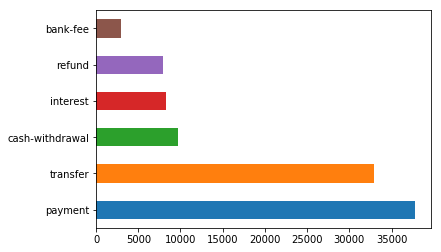

In [32]:
train_df['transaction_class'].value_counts().plot(kind='barh')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x138001c18>],
      dtype=object)

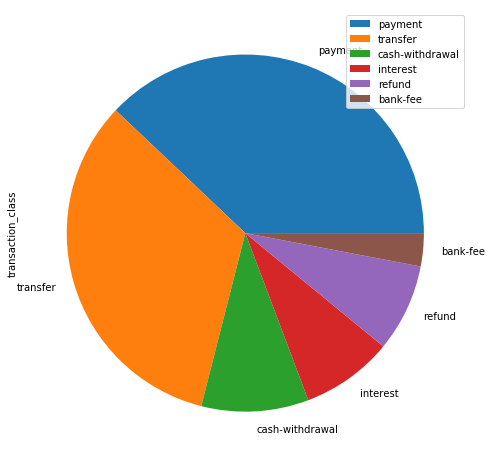

In [33]:
df = pd.DataFrame(train_df['transaction_class'].value_counts())
df.plot.pie(subplots=True, y='transaction_class', figsize=(8, 10))

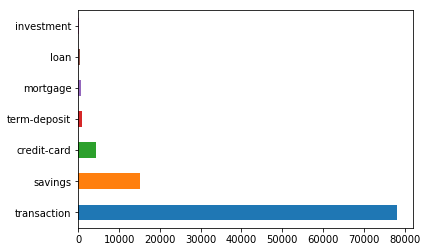

In [34]:
train_df['transaction_account_type'].value_counts().plot(kind='barh')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x136f73eb8>],
      dtype=object)

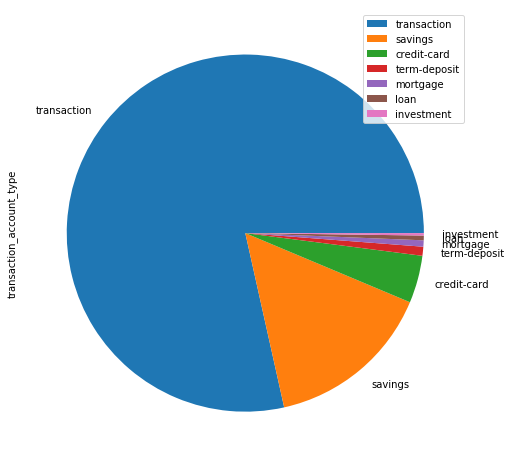

In [35]:
df = pd.DataFrame(train_df['transaction_account_type'].value_counts())
df.plot.pie(subplots=True, y='transaction_account_type', figsize=(8, 14))

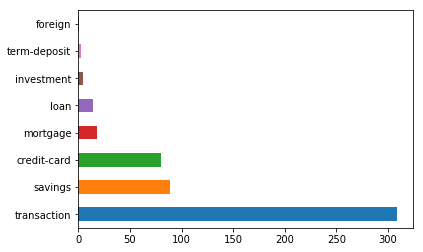

In [36]:
test_df['transaction_account_type'].value_counts().plot(kind='barh')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x136d902e8>],
      dtype=object)

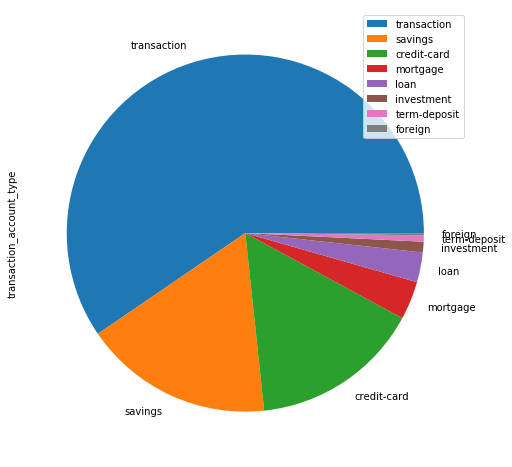

In [37]:
df = pd.DataFrame(test_df['transaction_account_type'].value_counts())
df.plot.pie(subplots=True, y='transaction_account_type', figsize=(8, 14))

##### Like we can see in data visualization of transaction_class and transaction_account_type, our data is pretty much unbalanced. Most of the transactions are distributed into transfer and payment transaction classes and the lower percent goes to cash-withdrawal, interest, refund and bank-fee. Regarding transaction_account_type, most of the transactions are distributed to transactions, savings and credit-card, and the lower percent goes to other transaction account types. After we create our model, we will need to check whether we need scaling of datasets. We will check accuracy and F1 score on less distributed transaction_account_types and transaction_classes, just to make sure if the model is predicting right values for classes that are distributed in lower percent. Let's go a little bit further with analysis.

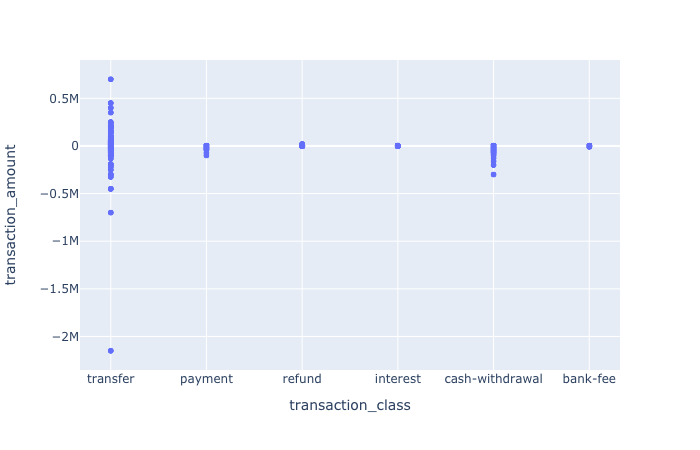

In [38]:
vis_1 = px.scatter(train_df,x="transaction_class",y="transaction_amount")
vis_1.show('png')

##### As we can see in this visualization, we have a lot of outliers in our dataset, so we need to handle that

In [52]:
train_df = train_df[np.abs(train_df["transaction_amount"]-train_df["transaction_amount"].mean()) 
                                                    <= (3*train_df["transaction_amount"].std())]
test_df = test_df[np.abs(test_df["transaction_amount"]-test_df["transaction_amount"].mean()) 
                                                 <= (3*test_df["transaction_amount"].std())]

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

##### Now we can see how our data look like after dropping outliers...

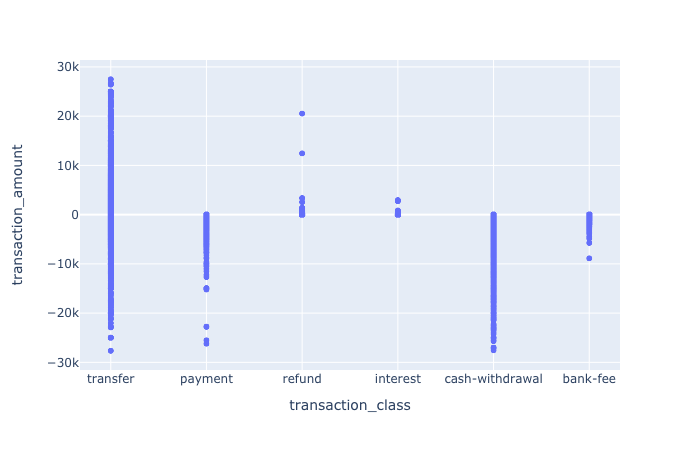

In [40]:
vis_1 = px.scatter(train_df,x="transaction_class",y="transaction_amount")
vis_1.show('png')

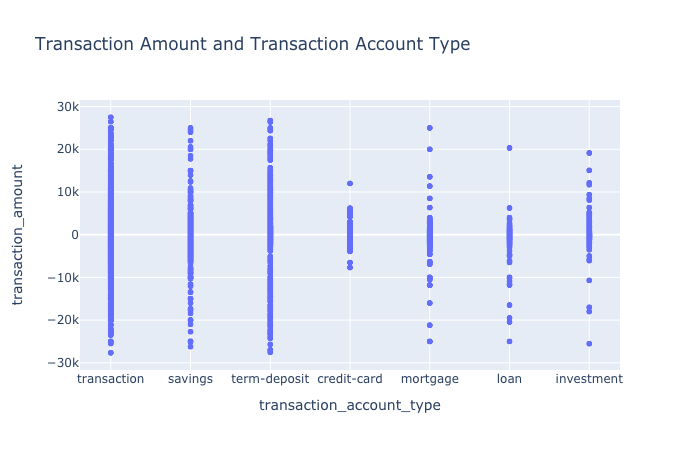

In [41]:
vis_4 = px.scatter(train_df,x="transaction_account_type",y="transaction_amount",title="Transaction Amount and Transaction Account Type")
vis_4.show('png')

##### Now we can do a little bit of data cleaning in the transaction_description column... 

In [43]:
def data_cleaning(dataframe_column):
    dataframe_column = dataframe_column.str.lower()
    dataframe_column = dataframe_column.str.replace('\d+', '')
    dataframe_column = dataframe_column.str.replace('xx', '')
    dataframe_column = dataframe_column.apply(lambda x: re.sub(' +', ' ', x))
    for char in punctuation:
        dataframe_column = dataframe_column.str.replace(char, "")
        
    return dataframe_column    
    

In [44]:
train_df['cleaned_transaction_description'] = data_cleaning(train_df['transaction_description'])
test_df['cleaned_transaction_description'] =  data_cleaning(test_df['transaction_description'])

##### Let's see how our descriptions looks like after data cleaning 

In [45]:
train_df['cleaned_transaction_description'].head()

0            anz internet banking funds tfer transfer 
1    visa debit purchase card vv trading pty ltd co...
2        return  direct debit elantis pf l value date 
3                   atm deposit handybank bondi beach 
4                                    pos wd eatat merr
Name: cleaned_transaction_description, dtype: object

In [46]:
test_df['cleaned_transaction_description'].head()

0    home phone bpay bill payment  receipt to telst...
1                                                 trf 
2                             easypay base balance fee
3                    direct credit mcare benefits aywq
4               olps primary netbank bpay ruby perosin
Name: cleaned_transaction_description, dtype: object

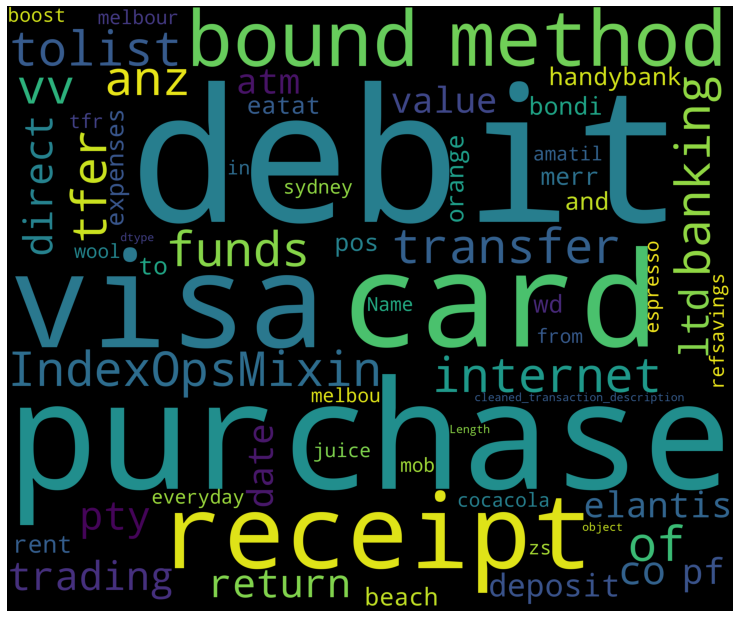

In [72]:
wordcloud = WordCloud(stopwords='english',
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(str(train_df['cleaned_transaction_description'].to_list))

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

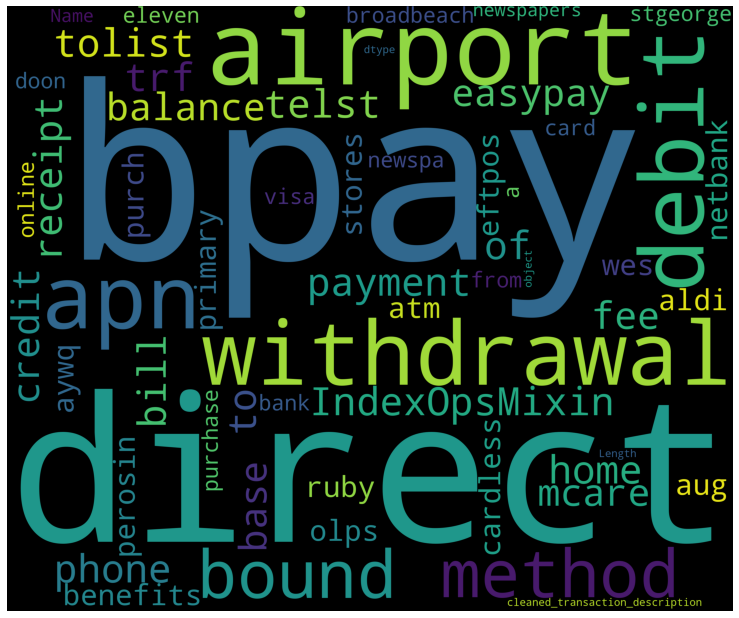

In [73]:
wordcloud = WordCloud(stopwords='english',
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(str(test_df['cleaned_transaction_description'].to_list))

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Now our transaction descriptions look better, but from this perspective it is hard to find a pattern in all these words and descriptions. We will try to develop our model first without getting into details about transaction description. First we need to encode our categorical data. Since all categories that we have in our dataset don't have ordinal relationships, we will do One Hot Encoding on them. We will create a separate data frame where we can test our model without getting deep into description details.

In [47]:
basic_model_train = train_df[['transaction_description', 'transaction_amount', 
                              'transaction_account_type', 'transaction_class', 'cleaned_transaction_description']]

basic_model_test = test_df[['cleaned_transaction_description', 'transaction_description', 
                            'transaction_amount', 'transaction_account_type']]

def handle_categorical_data(df):
    df['cleaned_transaction_description'] = df['cleaned_transaction_description'].apply(lambda row: word_tokenize(row)).apply(str)
    df['credit_or_debit'] = df['transaction_amount'].apply(lambda x: 'credit' if x < 0 else 'debit')
    df['credit_or_debit'] = df['credit_or_debit'].astype('category')
    df = pd.concat([df.drop(columns=['credit_or_debit']), pd.get_dummies(df['credit_or_debit'])], axis=1)
    df['transaction_account_type'] = df['transaction_account_type'].astype('category')
    df = pd.concat([df.drop(columns=['transaction_account_type']), pd.get_dummies(df['transaction_account_type'])], axis=1)
    df['cleaned_transaction_description'] = df['cleaned_transaction_description'].apply(lambda x: len(x))
    
    return df


In [48]:
basic_model_train = handle_categorical_data(basic_model_train)
basic_model_test = handle_categorical_data(basic_model_test)

In [49]:
basic_model_train.head()

,transaction_description,transaction_amount,transaction_class,cleaned_transaction_description,credit,debit,credit-card,investment,loan,mortgage,savings,term-deposit,transaction
0,ANZ INTERNET BANKING FUNDS TFER TRANSFER 77274...,-5000.00,transfer,59,1,0,0,0,0,0,0,0,1
1,VISA DEBIT PURCHASE CARD 4067 VV TRADING PTY L...,-6.50,payment,78,1,0,0,0,0,0,0,0,1
2,return 79/12/01 direct debit 374312 elantis pf...,0.15,refund,68,0,1,0,0,0,0,0,0,1
3,ATM DEPOSIT HANDYBANK BONDI BEACH 2 23718131 0...,50.00,transfer,49,0,1,0,0,0,0,0,0,1
4,POS W/D EATAT153 MERR-08:34,-10.50,payment,30,1,0,0,0,0,0,0,0,1


In [50]:
basic_model_test.head()

,cleaned_transaction_description,transaction_description,transaction_amount,credit,debit,credit-card,foreign,investment,loan,mortgage,savings,term-deposit,transaction
0,87,home phone BPAY Bill Payment - Receipt 250855 ...,-1.00,1,0,1,0,0,0,0,0,0,0
1,7,TRF 5191630231943012,2500.00,0,1,0,0,0,0,0,1,0,0
2,37,Easypay Base Balance Fee,-24.65,1,0,0,0,0,0,0,0,0,1
3,49,Direct Credit 002221 MCARE BENEFITS 220040444 ...,38.95,0,1,0,0,0,0,0,0,0,1
4,57,OLPS PRIMARY NetBank BPAY 515395 213241009454 ...,-533.00,1,0,0,0,0,0,0,0,0,1


##### Like you have seen I've created a new column for each transaction_acount_type and filled it with dummy variables(0,1). Also, for better performances of our potential model, I've transformed cleaned_transaction_description to length of transaction description. Let's see the correlation between variables and correlation between length of transaction description and transaction class...

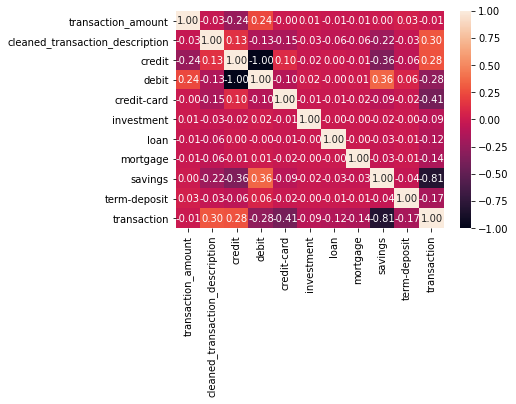

In [78]:
sns.heatmap(basic_model_train.corr(), annot=True, fmt=".2f")
plt.show()

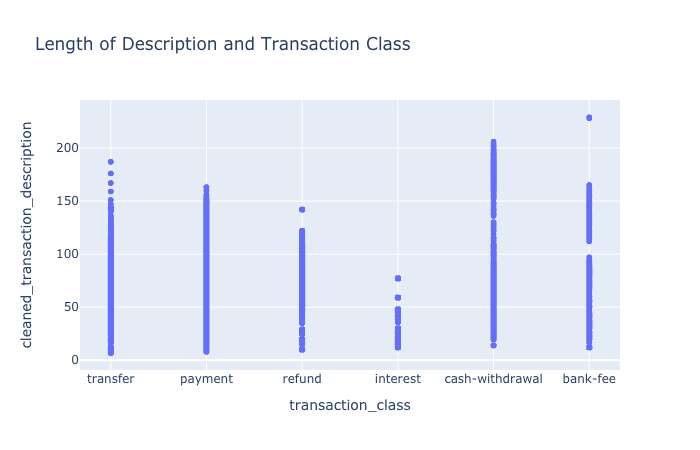

In [51]:
vis_3 = px.scatter(basic_model_train,x="transaction_class",y="cleaned_transaction_description",title="Length of Description and Transaction Class")
vis_3.show('png')

##### Ok, we will now create test and train datasets, and try to run our first ML model. We will start with Logistic regression and we will use Accuracy and F1 Score for metrics. Also, we will use cross validation, to see how our models are behaving on different parts of the dataset...

In [80]:
X_train = basic_model_train.drop(columns=["transaction_class", "transaction_description"])
y_train = basic_model_train["transaction_class"]
X_test = basic_model_test.drop(columns=["foreign", "transaction_description"])
X_test = X_test.reindex(sorted(X_test.columns), axis=1)
X_train = X_train.reindex(sorted(X_train.columns), axis=1)


In [81]:
logModel = LogisticRegression()
logModel.fit(X_train,y_train)
logModel_predicted_classes = logModel.predict(X_train)
print('Accurancy for LogisticRegression is: {}'.format(accuracy_score(y_train, logModel_predicted_classes)))
print("F1 SCORE FOR Logistic regression: {}".format(f1_score(y_train,logModel_predicted_classes,pos_label='positive',average='micro')))


Accurancy for LogisticRegression is: 0.4259602222401159
F1 SCORE FOR Logistic regression: 0.4259602222401159


##### Results are pretty much bad, and the possible reason for that is really unbalanced data. We will need to check other algorithms, clustering and tree based algorithms, where we don't have to oversample/undersample data to get better results. Let's try with KNN(K nearest neighbours).

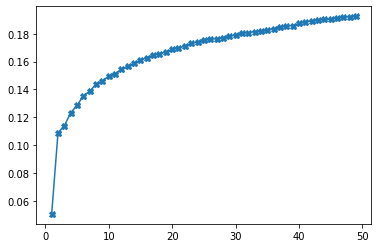

In [82]:
errors = []
for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_train)
    errors.append(np.mean(pred!=y_train))

plt.plot(range(1,50),errors,marker="X")
plt.show()



In [87]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred = knn.predict(X_train)
print("ACCURACY SCORE FOR KNN: {}".format(accuracy_score(y_train,pred)))
print("F1 SCORE FOR Logistic regression: {}".format(f1_score(y_train,pred,pos_label='positive',average='micro')))


ACCURACY SCORE FOR KNN: 0.8860918753522828
F1 SCORE FOR Logistic regression: 0.8860918753522828


##### These are really good results, let's see how the model is behaving at separate chunks of data, by involving cross validation…

In [88]:
scores = cross_val_score(knn, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.82049217 0.81666751 0.81841973 0.82264721 0.8194766 ]


##### We have lower accuracy on separate chunks of data. Also, to improve clustering algorithms, we will need to scale values in dataframe. So, to get better values, we will need to scale transaction_amount on range between 0 and 1. Let's try with a tree based algorithm. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance and we will use XGBClassifier with tuned hyperparameters. 

In [90]:
xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)

# Tuning
xgb1 = XGBClassifier(max_depth=9,
                     subsample = 1,
                     n_estimators = 300,
                     min_child_weight=1,
                     random_state=5,
                     reg_alpha=0,
                     reg_lambda=1,
                     learning_rate=0.3
                     )
xgb1.fit(X_train, y_train)
predicted_classes = xgb1.predict(X_train)
print("ACCURACY SCORE FOR XGBoost: {}".format(accuracy_score(y_train,predicted_classes)))
print("F1 SCORE FOR XGBoost: {}".format(f1_score(y_train,predicted_classes ,pos_label='positive',average='micro')))


ACCURACY SCORE FOR XGBoost: 0.9249838956437716
F1 SCORE FOR XGBoost: 0.9249838956437716


##### These are really good results. Let's do the cross validation and check the accuracy and F1 score on less distributed classes.

In [91]:
scores = cross_val_score(xgb1, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.86533139 0.86427457 0.86522396 0.86356316 0.86426774]


##### We will create a separate column in our dataframe and we will check metrics for less distributed classes.

In [93]:
basic_model_train['predicted_xgboost'] = predicted_classes

In [94]:
basic_model_train['predicted_xgboost'].value_counts()

payment            39026
transfer           31654
cash-withdrawal     9512
interest            8285
refund              7884
bank-fee            2991
Name: predicted_xgboost, dtype: int64

In [95]:
basic_model_train['transaction_class'].value_counts()

payment            37760
transfer           32804
cash-withdrawal     9608
interest            8283
refund              7914
bank-fee            2983
Name: transaction_class, dtype: int64

##### When we compare predicted and actual results, we can see that our model is predicting really well on train dataset, even for low distributed classes. Let's run our model on a test dataset, and see the results...

In [96]:
predicted_values_test_set = xgb1.predict(X_test)

In [97]:
pd.DataFrame(predicted_values_test_set).value_counts()

transfer           194
payment            174
bank-fee            69
cash-withdrawal     38
interest            28
refund              13
dtype: int64

##### Those results seem to follow the same order from the train dataset. We will create a separate data frame for the test dataset and store our results in a csv file. 

In [100]:
final_score_card_df = test_df[['transaction_description', 'transaction_amount', 'transaction_account_type']]
final_score_card_df['transaction_class_predicted'] = predicted_values_test_set

In [101]:
final_score_card_df.head()

,transaction_description,transaction_amount,transaction_account_type,transaction_class_predicted
0,home phone BPAY Bill Payment - Receipt 250855 ...,-1.00,credit-card,payment
1,TRF 5191630231943012,2500.00,savings,transfer
2,Easypay Base Balance Fee,-24.65,transaction,transfer
3,Direct Credit 002221 MCARE BENEFITS 220040444 ...,38.95,transaction,transfer
4,OLPS PRIMARY NetBank BPAY 515395 213241009454 ...,-533.00,transaction,transfer


In [102]:
final_score_card_df_basic = final_score_card_df.to_csv(DATA_PATH + 'final_scorecard_basic_ml.csv')

##### Now when we have stored our results in a csv file, we can check metrics on less each class…

In [103]:
def metrics_for_each_class(df, transaction_class, model, predicted_values_column):
    df = df[df['transaction_class'] == transaction_class]
    acc_score = accuracy_score(df['transaction_class'], df[predicted_values_column])
    f1_score_result = f1_score(df['transaction_class'], df[predicted_values_column],pos_label='positive',average='micro')
    print("ACCURACY SCORE FOR {} for class {}: {}".format(model, transaction_class, acc_score))
    print("F1 SCORE FOR {} for class {}: {}".format(model, transaction_class, f1_score_result))

In [105]:
metrics_for_each_class(basic_model_train, 'bank-fee', 'XGBoost', 'predicted_xgboost')

ACCURACY SCORE FOR XGBoost for class bank-fee: 0.9601072745558162
F1 SCORE FOR XGBoost for class bank-fee: 0.9601072745558162


In [106]:
metrics_for_each_class(basic_model_train, 'refund', 'XGBoost', 'predicted_xgboost')

ACCURACY SCORE FOR XGBoost for class refund: 0.9958301743745261
F1 SCORE FOR XGBoost for class refund: 0.9958301743745261


In [107]:
metrics_for_each_class(basic_model_train, 'interest', 'XGBoost', 'predicted_xgboost')

ACCURACY SCORE FOR XGBoost for class interest: 1.0
F1 SCORE FOR XGBoost for class interest: 1.0


In [109]:
metrics_for_each_class(basic_model_train, 'payment', 'XGBoost', 'predicted_xgboost')

ACCURACY SCORE FOR XGBoost for class payment: 0.9476430084745763
F1 SCORE FOR XGBoost for class payment: 0.9476430084745763


In [110]:
metrics_for_each_class(basic_model_train, 'transfer', 'XGBoost', 'predicted_xgboost')

ACCURACY SCORE FOR XGBoost for class transfer: 0.8924521399829289
F1 SCORE FOR XGBoost for class transfer: 0.8924521399829288


##### Like we can see, our model is performing well on both, less distributed classes and more distributed classes...

Feature: 0, Score: 0.01178
Feature: 1, Score: 0.44267
Feature: 2, Score: 0.05213
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.01180
Feature: 5, Score: 0.01061
Feature: 6, Score: 0.00743
Feature: 7, Score: 0.30280
Feature: 8, Score: 0.03953
Feature: 9, Score: 0.10120
Feature: 10, Score: 0.02005


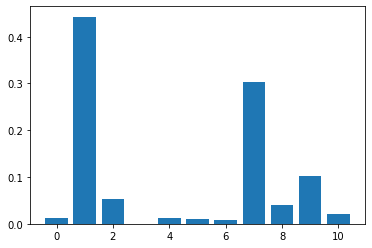

In [1242]:
importance = xgb1.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

##### In this feature importance bar, we can see that we can exclude card or debit columns and one of the transaction account types columns, but for now, it's not improving results a lot...

### Model with description tokenization and vectorization

##### Ok, now we will try some different approaches. We know that some information about the transaction class is hiding in transaction_description. Also we know that we need some kind of numerical representations of our descriptions. First thing that we need to do is to tokenize our descriptions. Tokenization is the process of converting text into tokens before transforming it into vectors. It is also easier to filter out unnecessary tokens. For example, a document into paragraphs or sentences into words. In this case we are tokenizing the transaction descriptions into words. After that we will use Tfidfvectorizer to convert words into vectors.

In [53]:
vectorization_model_train = train_df[['transaction_description', 'transaction_amount', 'transaction_account_type', 
                                      'transaction_class', 'cleaned_transaction_description']]

vectorization_model_test = test_df[['cleaned_transaction_description', 'transaction_description', 
                                    'transaction_amount', 'transaction_account_type']]

vectorization_model_train = vectorization_model_train.reindex(sorted(vectorization_model_train.columns), axis=1)
vectorization_model_test = vectorization_model_test.reindex(sorted(vectorization_model_test.columns), axis=1)

##### Since we can't combine vectors and other data types in our dataframe, we will combine all independent variables in one column. I know, it's weird. After that we will do tokenization, so we can transform those tokens/descriptions into vectors.

In [62]:
def combine_features(features):
    features_combined = []
    for i in range(features.shape[0]):
        features_combined.append(features["cleaned_transaction_description"][i] + ' ' +
                                 features["transaction_account_type"][i]  + ' ' +
                                 features["credit_or_debit"][i])
    return features_combined 

In [63]:
def preparing_data_for_vectorizing(df):
    df["credit_or_debit"] = df['transaction_amount'].apply(lambda x: 'credit' if x < 0 else 'debit')
    df["combine_desc"] = combine_features(df)
    df["combine_desc"] = df['combine_desc'].apply(lambda row: word_tokenize(row)).apply(str)
    
    return df["combine_desc"]
    

In [64]:
tokenized_train_data = preparing_data_for_vectorizing(vectorization_model_train)
tokenized_test_data = preparing_data_for_vectorizing(vectorization_model_test)


##### TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. That means that, with TfidfVectorizer, we will create a sparse matrix that will represent the weight of how often certain words occur in the document. We will convert tokenized_train_data and tokenized_test_data into a sparse matrix, and we will train and test our models on it.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(use_idf=True, smooth_idf=False, stop_words='english')
tf.fit(tokenized_train_data)

X_train = tf.transform(tokenized_train_data)
y_train = vectorization_model_train["transaction_class"]
X_test = tf.transform(tokenized_test_data)

##### We will try first with LogisticRegression

In [297]:
logModel = LogisticRegression()
logModel.fit(X_train,y_train)
predicted_logistic_reg = logModel.predict(X_train)
print('Accurancy for LogisticRegression is: {}'.format(accuracy_score(y_train, predicted_logistic_reg)))
print("F1 SCORE FOR Logistic regression: {}".format(f1_score(y_train, predicted_logistic_reg, pos_label='positive',average='micro')))


Accurancy for LogisticRegression is: 0.9964973025203318
F1 SCORE FOR Logistic regression: 0.9964973025203318


In [337]:
scores = cross_val_score(logModel, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.99446429 0.99350813 0.99506794 0.99391042 0.9935078 ]


##### These are really good results, but let's try one more time with XGBoost...

In [311]:
xgbmodel = XGBClassifier(max_depth=9,
                     subsample = 1,
                     n_estimators = 300,
                     min_child_weight=1,
                     random_state=5,
                     reg_alpha=0,
                     reg_lambda=1,
                     learning_rate=0.3
                     )
xgbmodel.fit(X_train, y_train)
predicted_xgb_model = xgbmodel.predict(X_train)

xgbmodel.fit(X_train, y_train)
print("ACCURACY SCORE FOR XGBoost: {}".format(accuracy_score(y_train,predicted_xgb_model)))
print("F1 SCORE FOR XGBoost: {}".format(f1_score(y_train,predicted_xgb_model,pos_label='positive',average='micro')))

ACCURACY SCORE FOR XGBoost: 0.999708108543361
F1 SCORE FOR XGBoost: 0.999708108543361


In [338]:
scores = cross_val_score(xgbmodel, X_train, y_train, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.9973328  0.9973328  0.99788626 0.99713135 0.99708103]


##### Like we can see, these results are really good, so let's try to see how our model is performing on each separate transaction class. We will create a new column in vectorization_model_train with results of our prediction and calculate metrics with metrics_for_each_class function...

In [324]:
vectorization_model_train['predicted_classes'] = predicted_xgb_model

In [326]:
metrics_for_each_class(vectorization_model_train, 'bank-fee', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class bank-fee: 0.9973181361045927
F1 SCORE FOR XGBoost for class bank-fee: 0.9973181361045927


In [328]:
metrics_for_each_class(vectorization_model_train, 'refund', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class refund: 1.0
F1 SCORE FOR XGBoost for class refund: 1.0


In [334]:
metrics_for_each_class(vectorization_model_train, 'interest', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class interest: 0.9996378123868164
F1 SCORE FOR XGBoost for class interest: 0.9996378123868164


In [335]:
metrics_for_each_class(vectorization_model_train, 'cash-withdrawal', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class cash-withdrawal: 0.9988551207327228
F1 SCORE FOR XGBoost for class cash-withdrawal: 0.9988551207327228


In [332]:
metrics_for_each_class(vectorization_model_train, 'payment', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class payment: 0.9998411016949152
F1 SCORE FOR XGBoost for class payment: 0.9998411016949152


In [333]:
metrics_for_each_class(vectorization_model_train, 'transfer', 'XGBoost', 'predicted_classes')

ACCURACY SCORE FOR XGBoost for class transfer: 0.9999695159126936
F1 SCORE FOR XGBoost for class transfer: 0.9999695159126936


##### As we can see, the XGBoost vectorizing model is performing really well in every class, so we will run that model on our test data, and store it in a csv file...

In [ ]:
predicted_classes_xgboost_vectorizer = xgbmodel.predict(X_test)

In [316]:
final_scorecard_df_vectorize = test_df[['transaction_description', 'transaction_amount', 'transaction_account_type']]
final_scorecard_df_vectorize['transaction_class'] = predicted_classes_xgboost_vectorizer

In [343]:
final_scorecard_df_vectorize.head()

,transaction_description,transaction_amount,transaction_account_type,transaction_class
0,home phone BPAY Bill Payment - Receipt 250855 ...,-1.00,credit-card,payment
1,TRF 5191630231943012,2500.00,savings,transfer
2,Easypay Base Balance Fee,-24.65,transaction,bank-fee
3,Direct Credit 002221 MCARE BENEFITS 220040444 ...,38.95,transaction,transfer
4,OLPS PRIMARY NetBank BPAY 515395 213241009454 ...,-533.00,transaction,payment


In [336]:
final_scorecard_df_vectorize.to_csv(DATA_PATH + 'final_scorecard_vectorized_ml.csv')

### Comments on vectorization model with potential improvements

###### Despite our vectorization model is giving good results on our train dataset, and on datasets of same size like train dataset, it will be overloading to create sparse matrix of more columns and rows, without deep understanding, analysis and finding patterns in text data. For example, let's try to see how our sparse matrix will look like if we convert it into a dataframe...

In [66]:
def convert_sparse_matrix_to_df(vectorizer, df_column):
    matrix = vectorizer.fit_transform(df_column)
    words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
    return words_df


In [67]:
convert_sparse_matrix_to_df(tf, tokenized_train_data).head()

,aa,aaa,aaaacd,aaae,aaafdc,aabaecbd,aabbcc,aabfaca,aacbd,aaccbcf,...,zux,zuz,zuza,zvmyfwsa,zvpdz,zvxq,zwift,zwldv,zydistro,zyiuk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### It looks really complex... Every word has its own weight frequency through the columns and rows. Most of the words are appearing only once in the dataset. In some cases where description has more importance, we will need to clean this matrix/dataset and to leave only most frequent descriptions, words and n-grams per class. I've tried to create a structure for it...

In [349]:
from collections import Counter

def get_ordered_dict(dataframe, trans_class=None):
    if trans_class is not None:
        dataframe = dataframe[dataframe['transaction_class'] == trans_class]
    df_column = dataframe['cleaned_transaction_description']
    column_list = df_column.tolist()
    l = [l.split() for l in column_list]
    new_list = [word for lt in l for word in lt]
    refund_dict = dict(Counter(new_list))
    ordered_by_value_dict = {k: v for k, v in sorted(refund_dict.items(), key=lambda item: item[1], reverse=True)}
    return ordered_by_value_dict

def get_n_most_common_desc(dataframe, n, transaction_class=None):
    if transaction_class is not None:
        dataframe = dataframe[dataframe['transaction_class'] == transaction_class]
    df_column = dataframe['cleaned_transaction_description']
    result = dict(Counter(df_column.to_list()).most_common(n))
    return result

import re

def generate_ngrams(s, n):
    tokens = [token for token in s.split(" ") if token != ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]
    
def most_common_ngrams(df, n_of_most_common, n, transaction_class=None):
    if transaction_class is not None:
        df = df[df['transaction_class'] == transaction_class]
    df_column = df['cleaned_transaction_description'].apply(lambda x: generate_ngrams(x, n))
    column_list = df_column.tolist()
    new_list = [word for lt in column_list for word in lt]
    result = dict(Counter(new_list).most_common(n_of_most_common))
    return result    



##### For example we can first analyze most common words through every class

In [360]:
Counter(get_ordered_dict(vectorization_model_train, trans_class='payment')).most_common(10)

[('card', 23476),
 ('purchase', 18784),
 ('aus', 12098),
 ('visa', 11343),
 ('date', 11078),
 ('debit', 11018),
 ('receipt', 7435),
 ('in', 6661),
 ('pos', 4737),
 ('wd', 4722)]

##### Or number of most common descriptions per each class or per whole dataframe

In [353]:
get_n_most_common_desc(train_df, 10, transaction_class='transfer')

{'transfer to commbank app': 942,
 'anz mbanking funds tfer transfer to ': 789,
 'internal transfer  internal transfer  receipt savings maximiser ': 750,
 'transfer from commbank app': 745,
 'anz mbanking funds tfer transfer from ': 678,
 'tfr from s mob': 648,
 'everyday round up  everyday round up  receipt oe card transaction  transfer to savings maximiser acc ': 614,
 'internal transfer  receipt  to orange everyday ': 528,
 'deposit online tfr westpac choice': 496,
 'deposit online tfr westpac esaver': 477}

##### And, I believe it could be very useful, to analyze n-grams per class per dataframe...

In [354]:
most_common_ngrams(train_df, n_of_most_common=13, n=3, transaction_class='bank-fee')

{'international transaction fee': 737,
 'transaction fee receipt': 501,
 'atm owner charge': 407,
 'atm operator fee': 298,
 'fee value date': 238,
 'transaction fee value': 236,
 'fee withdrawal at': 226,
 'operator fee withdrawal': 222,
 'nab intnl tran': 179,
 'intnl tran fee': 179,
 'foreign transaction fee': 149,
 'v foreign currency': 135,
 'foreign currency tran': 135}

##### After that analysis, we should clean our dataset/sparse matrix and leave only the most frequent words, descriptions and n-grams per transaction class.  After binding most frequent description structures with classes, it will be a good idea to create RNN...

In [71]:
final_vector = pd.read_csv(DATA_PATH + '/payment_classification/data/final_scorecard_vectorized_ml.csv/')

FileNotFoundError: File b'../payment_classification/data//payment_classification/data/final_scorecard_vectorized_ml.csv/' does not exist